# Problem Statement
<b>
You are hired by one of the leading news channels CNBE who wants to analyze recent elections. This survey was conducted on 1525 voters with 9 variables. You have to build a model, to predict which party a voter will vote for on the basis of the given information, to create an exit poll that will help in predicting overall win and seats covered by a particular party.


In [611]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt   
import seaborn as sns
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve, classification_report, confusion_matrix, plot_confusion_matrix, plot_roc_curve
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score,f1_score, recall_score

from sklearn.preprocessing import scale
# For preprocessing the data
from sklearn import preprocessing

# To model the Gaussian Navie Bayes classifier
from sklearn.naive_bayes import GaussianNB
from scipy.stats import zscore
import re # this is the regular expression library which helps us search for or extract matching patterns from a given string
import nltk # this is the Natural Language Tool Kit which contains a lot of functionalities for text analytics

import string # this is used for string manipulations
import warnings
warnings.filterwarnings('ignore')

In [612]:
df = pd.read_excel('Election_Data.xlsx', sheet_name=1).drop("Unnamed: 0",axis=1)


## Data description and Inferences

In [613]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1525 entries, 0 to 1524
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   vote                     1525 non-null   object
 1   age                      1525 non-null   int64 
 2   economic.cond.national   1525 non-null   int64 
 3   economic.cond.household  1525 non-null   int64 
 4   Blair                    1525 non-null   int64 
 5   Hague                    1525 non-null   int64 
 6   Europe                   1525 non-null   int64 
 7   political.knowledge      1525 non-null   int64 
 8   gender                   1525 non-null   object
dtypes: int64(7), object(2)
memory usage: 107.4+ KB


In [614]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,1525.0,54.182295,15.711209,24.0,41.0,53.0,67.0,93.0
economic.cond.national,1525.0,3.245902,0.880969,1.0,3.0,3.0,4.0,5.0
economic.cond.household,1525.0,3.140328,0.929951,1.0,3.0,3.0,4.0,5.0
Blair,1525.0,3.334426,1.174824,1.0,2.0,4.0,4.0,5.0
Hague,1525.0,2.746885,1.230703,1.0,2.0,2.0,4.0,5.0
Europe,1525.0,6.728525,3.297538,1.0,4.0,6.0,10.0,11.0
political.knowledge,1525.0,1.542295,1.083315,0.0,0.0,2.0,2.0,3.0


## Data walkthrough (head() .info(), shape)

In [615]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1525 entries, 0 to 1524
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   vote                     1525 non-null   object
 1   age                      1525 non-null   int64 
 2   economic.cond.national   1525 non-null   int64 
 3   economic.cond.household  1525 non-null   int64 
 4   Blair                    1525 non-null   int64 
 5   Hague                    1525 non-null   int64 
 6   Europe                   1525 non-null   int64 
 7   political.knowledge      1525 non-null   int64 
 8   gender                   1525 non-null   object
dtypes: int64(7), object(2)
memory usage: 107.4+ KB


In [616]:
df.head()

,vote,age,economic.cond.national,economic.cond.household,Blair,Hague,Europe,political.knowledge,gender
0,Labour,43,3,3,4,1,2,2,female
1,Labour,36,4,4,4,4,5,2,male
2,Labour,35,4,4,5,2,3,2,male
3,Labour,24,4,2,2,1,4,0,female
4,Labour,41,2,2,1,1,6,2,male


In [617]:
df.shape

(1525, 9)

## Data validation (Null check, Summary and Skewness) Exploratory Data Analysis (Null, Data Types, Shape, Univariate & Bivariate Analysis, Outliers)

In [618]:
df.isnull().sum()

vote                       0
age                        0
economic.cond.national     0
economic.cond.household    0
Blair                      0
Hague                      0
Europe                     0
political.knowledge        0
gender                     0
dtype: int64

In [619]:
df.duplicated().sum()

8

In [620]:
print('Data frame shape is', df.shape)
print('Duplicated no:', df.duplicated().sum())
df.drop_duplicates(inplace=True)
print('After removing duplicates ', df.duplicated().sum())

Data frame shape is (1525, 9)
Duplicated no: 8
After removing duplicates  0


In [621]:
df.shape

(1517, 9)

### Check for the spread of non-numeric data

In [622]:
for feature in df.columns: 
    if df[feature].dtype == 'object': 
        print(feature, ' Number of Levels', df[feature].nunique())
        print(df[feature].value_counts())
        print('\n')

vote  Number of Levels 2
Labour          1057
Conservative     460
Name: vote, dtype: int64


gender  Number of Levels 2
female    808
male      709
Name: gender, dtype: int64




### Check for Outliers

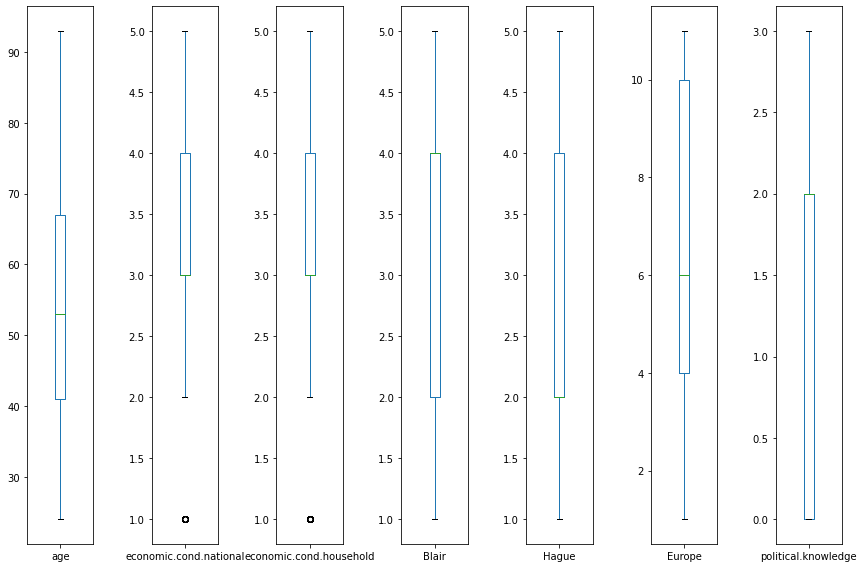

In [623]:
cols = ['age','economic.cond.national','economic.cond.household','Blair', 'Hague', 'Europe', 'political.knowledge']
df[cols].plot(kind = 'box',subplots=True, figsize = (12,8));
plt.tight_layout();

### Check for Correlations

In [624]:
df.corr().round(2)

,age,economic.cond.national,economic.cond.household,Blair,Hague,Europe,political.knowledge
age,1.00,0.02,-0.04,0.03,0.03,0.06,-0.05
economic.cond.national,0.02,1.00,0.35,0.33,-0.20,-0.21,-0.02
economic.cond.household,-0.04,0.35,1.00,0.22,-0.10,-0.11,-0.04
Blair,0.03,0.33,0.22,1.00,-0.24,-0.30,-0.02
Hague,0.03,-0.20,-0.10,-0.24,1.00,0.29,-0.03
Europe,0.06,-0.21,-0.11,-0.30,0.29,1.00,-0.15
political.knowledge,-0.05,-0.02,-0.04,-0.02,-0.03,-0.15,1.00


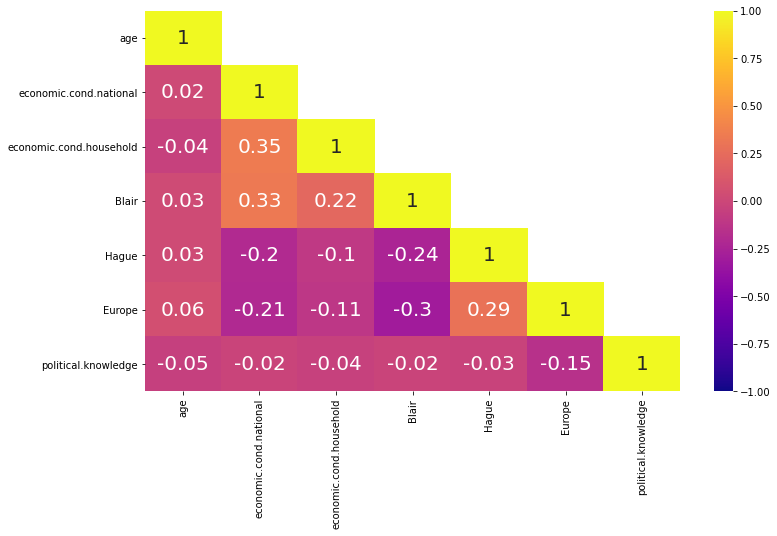

In [625]:
plt.figure(figsize=(12,7))
sns.heatmap(df.corr().round(2), cmap='plasma', vmin=-1, 
            vmax=1, annot=True,
            annot_kws={'size':20},
            mask=np.triu(df.corr(),+1))
plt.yticks(rotation = 0);

### Uni variate, Bi Variate and Multi variate analysis

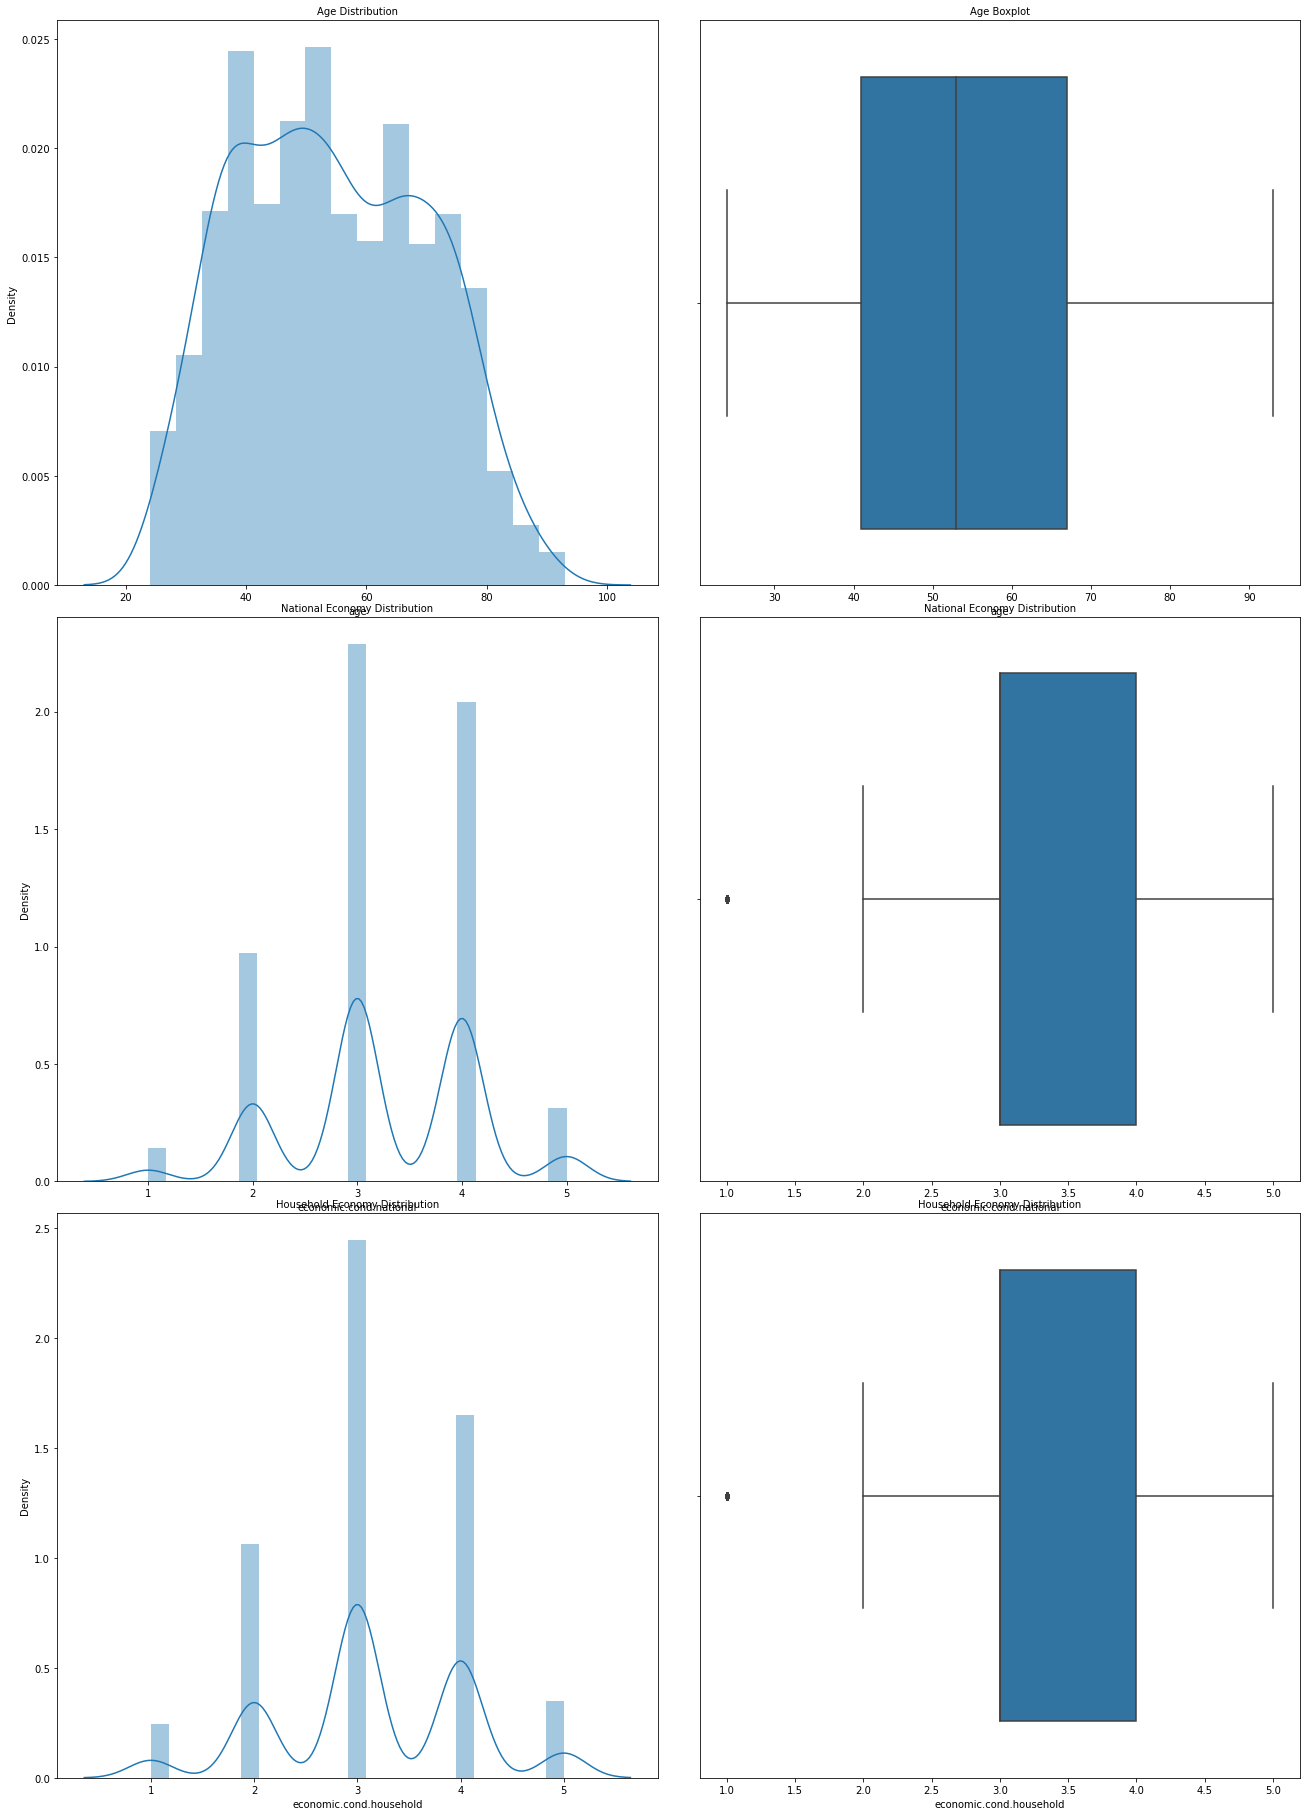

In [626]:
fig, axes = plt.subplots(nrows=3,ncols=2)
fig.set_size_inches(18,25)
fig.tight_layout()

a = sns.distplot(df['age'] , ax=axes[0][0])
a.set_title("Age Distribution",fontsize=10)

a = sns.boxplot(df['age'] , orient = "v" , ax=axes[0][1])
a.set_title("Age Boxplot",fontsize=10)

a = sns.distplot(df['economic.cond.national'] , ax=axes[1][0])
a.set_title("National Economy Distribution",fontsize=10)

a = sns.boxplot(df['economic.cond.national'] , orient = "v" , ax=axes[1][1])
a.set_title("National Economy Distribution",fontsize=10)

a = sns.distplot(df['economic.cond.household'] , ax=axes[2][0])
a.set_title("Household Economy Distribution",fontsize=10)

a = sns.boxplot(df['economic.cond.household'] , orient = "v" , ax=axes[2][1])
a.set_title("Household Economy Distribution",fontsize=10)

plt.show()

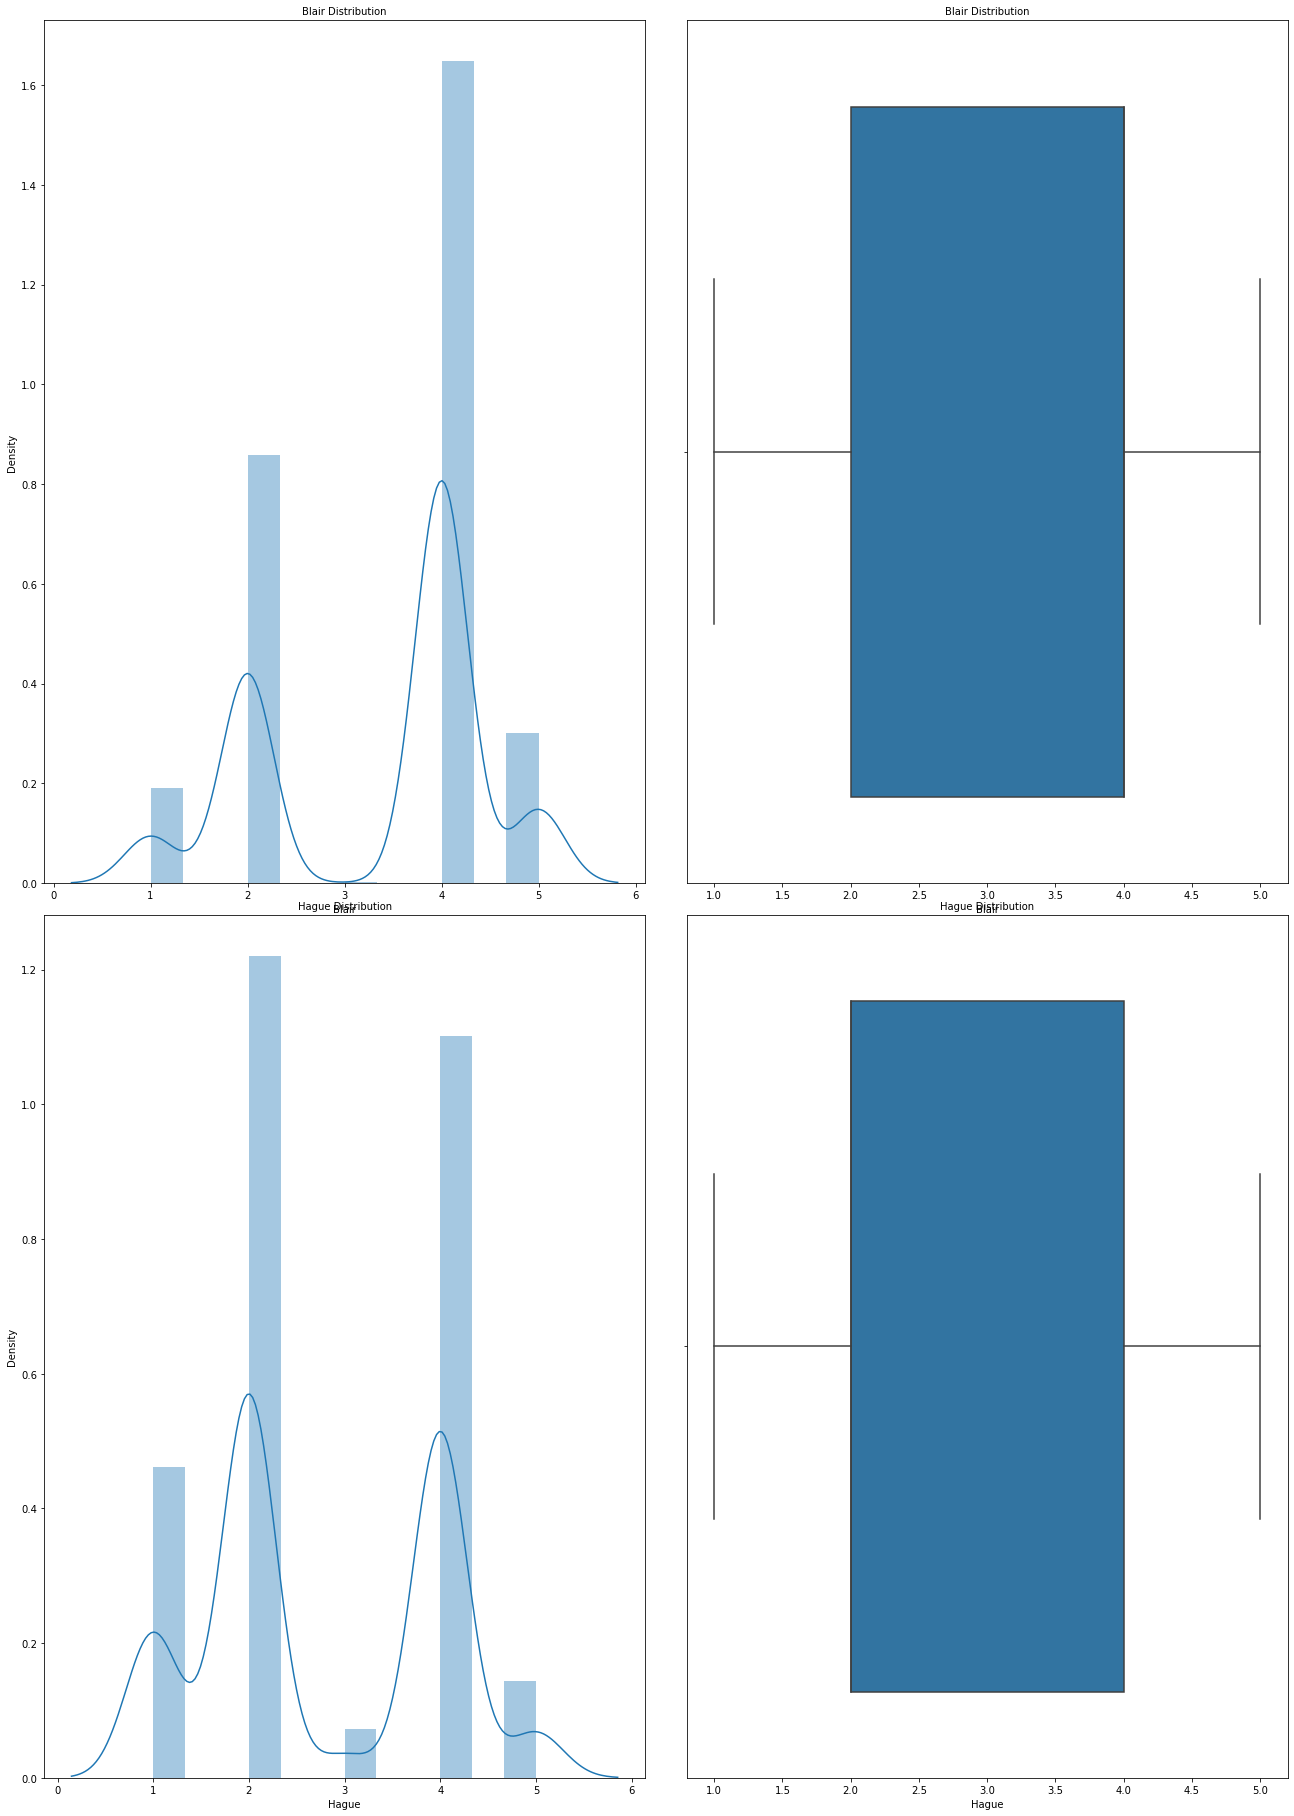

In [627]:
fig, axes = plt.subplots(nrows=2,ncols=2)
fig.set_size_inches(18,25)
fig.tight_layout()


a = sns.distplot(df['Blair'] , ax=axes[0][0])
a.set_title("Blair Distribution",fontsize=10)

a = sns.boxplot(df['Blair'] , orient = "v" , ax=axes[0][1])
a.set_title("Blair Distribution",fontsize=10)

a = sns.distplot(df['Hague'] , ax=axes[1][0])
a.set_title("Hague Distribution",fontsize=10)

a = sns.boxplot(df['Hague'] , orient = "v" , ax=axes[1][1])
a.set_title("Hague Distribution",fontsize=10)

plt.show()

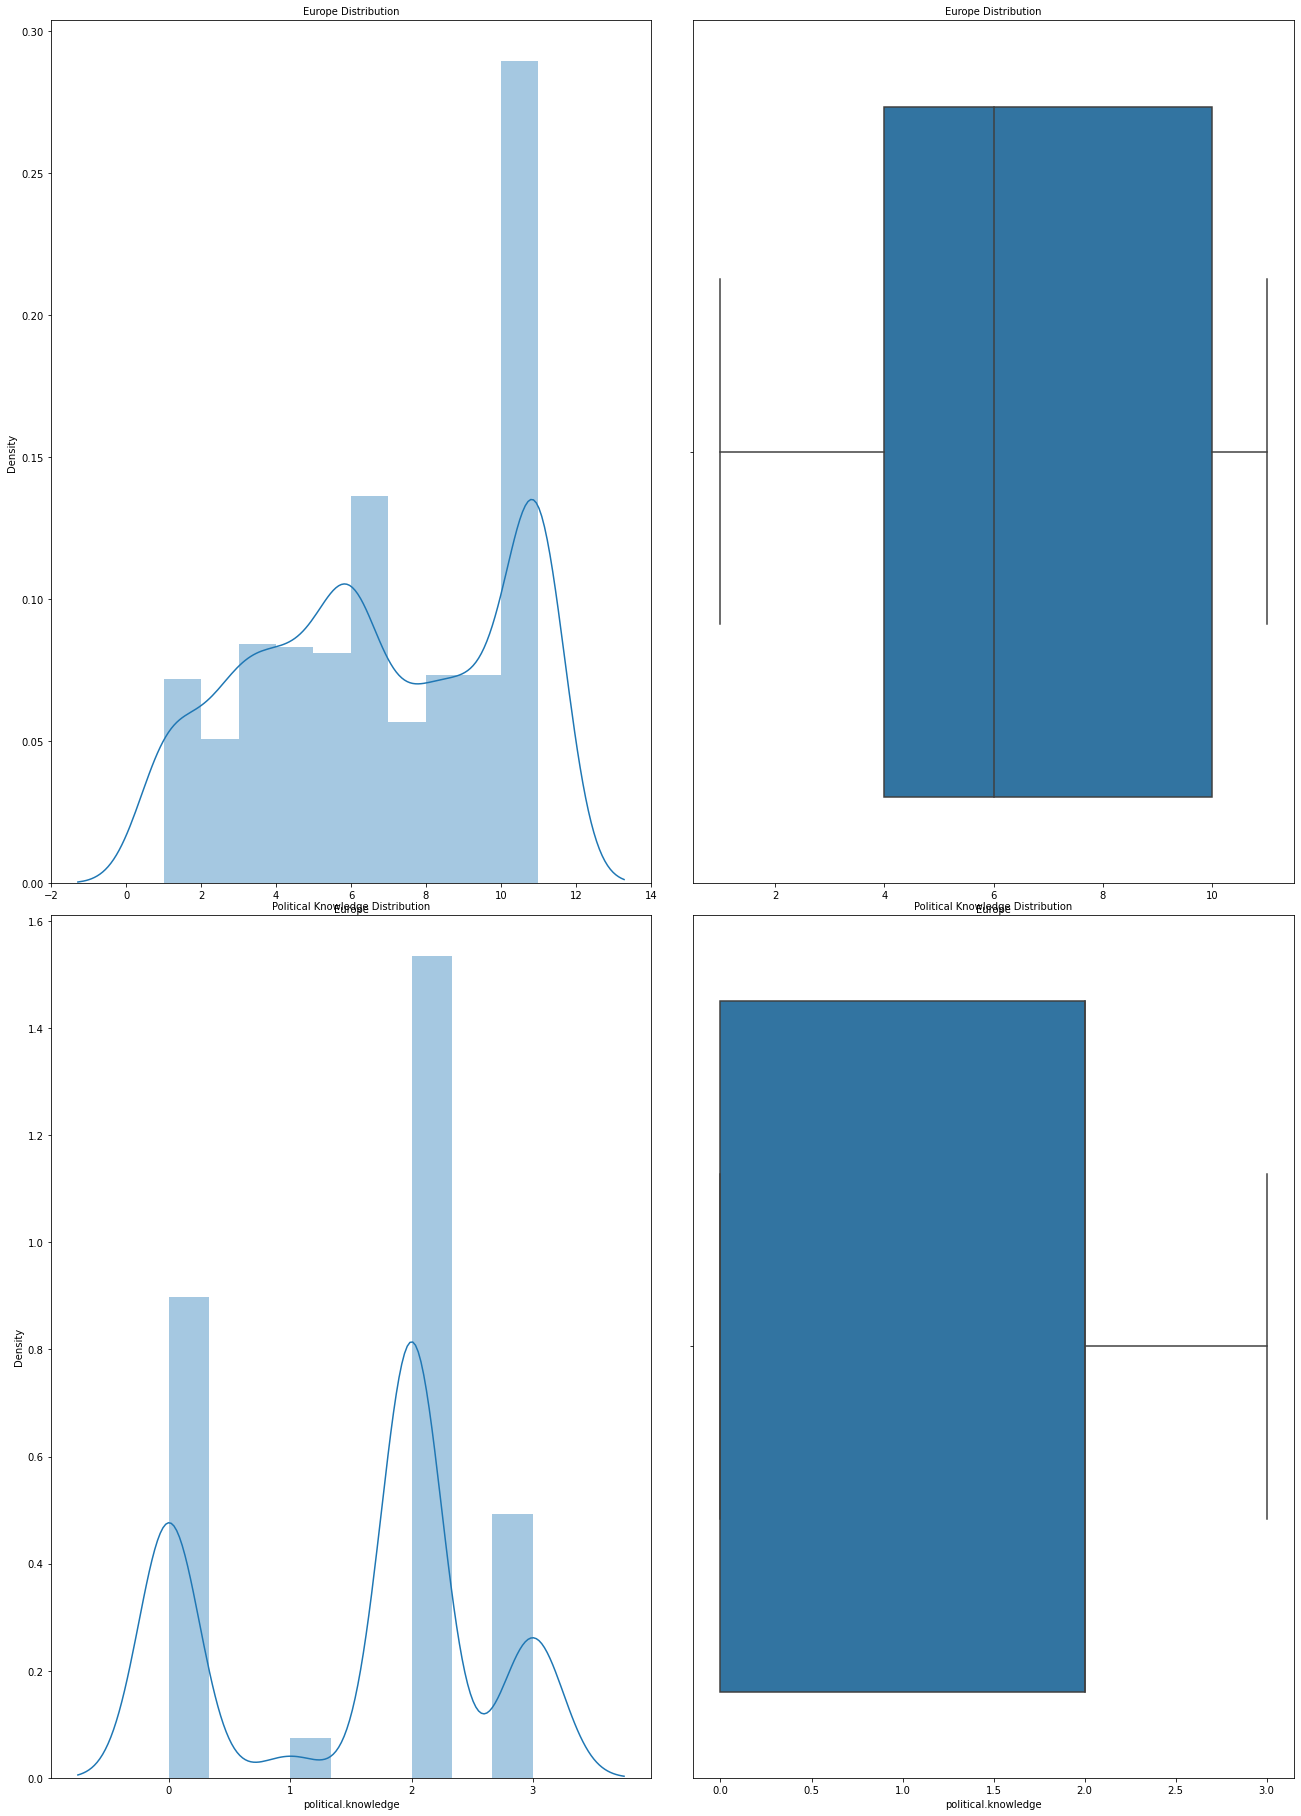

In [628]:
fig, axes = plt.subplots(nrows=2,ncols=2)
fig.set_size_inches(18,25)
fig.tight_layout()


a = sns.distplot(df['Europe'] , ax=axes[0][0])
a.set_title("Europe Distribution",fontsize=10)

a = sns.boxplot(df['Europe'] , orient = "v" , ax=axes[0][1])
a.set_title("Europe Distribution",fontsize=10)

a = sns.distplot(df['political.knowledge'] , ax=axes[1][0])
a.set_title("Political Knowledge Distribution",fontsize=10)

a = sns.boxplot(df['political.knowledge'] , orient = "v" , ax=axes[1][1])
a.set_title("Political Knowledge Distribution",fontsize=10)

plt.show()

Target Variable vs Independent Variable

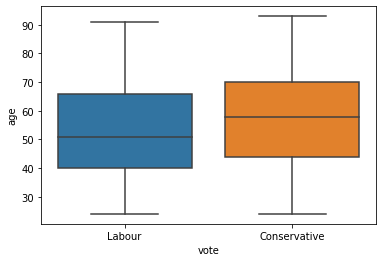

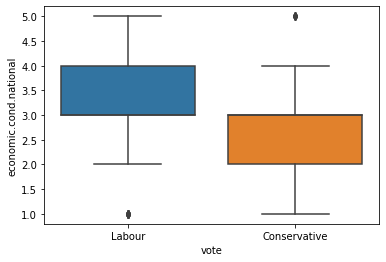

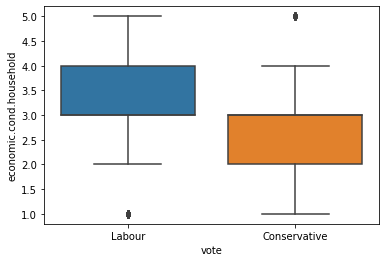

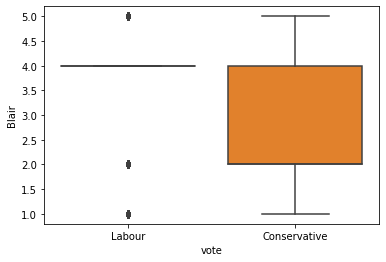

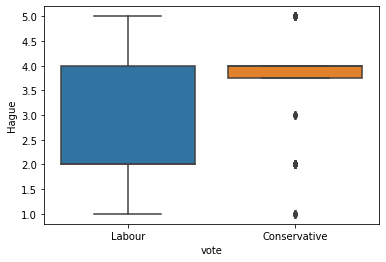

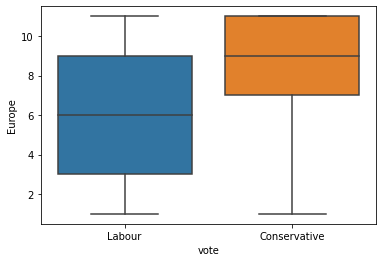

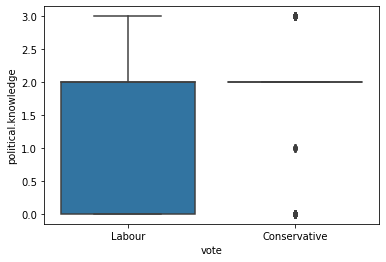

In [629]:
for col in cols:
    sns.boxplot(data=df, x='vote', y=col)
    plt.show()

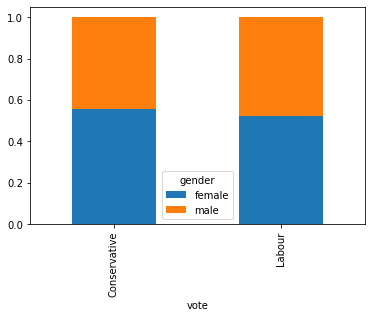

In [630]:
tab = pd.crosstab(df['vote'],df['gender'],normalize='index')
tab.plot(kind='bar',stacked = True)
plt.show();

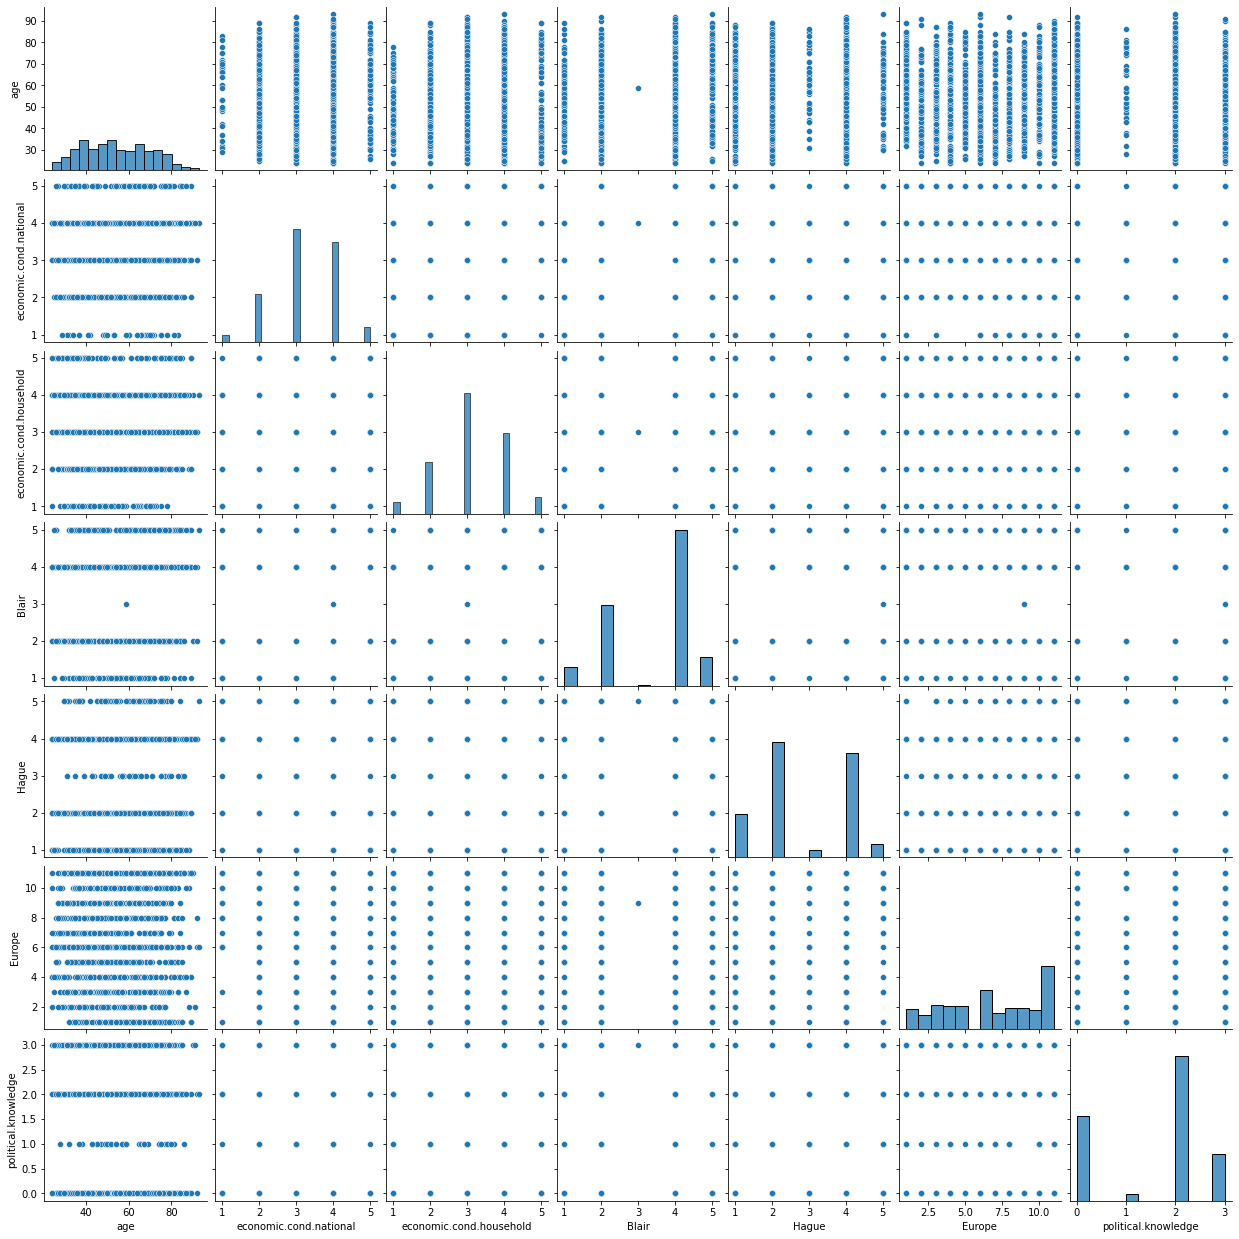

In [631]:
# Pairplot using sns
sns.pairplot(df ,diag_kind='hist');

## Data Encoding and Scaling

### Encode the data for the features with String Values. Is Scaling necessary or not? Check the 5-point summary to support the Scaling. Object data should be converted into Categorical/Number type and fit to models.

In [632]:
df_dummy = pd.get_dummies(df,drop_first=True)
df_dummy.head()
df_dummy['vote_Labour'] = df_dummy['vote_Labour'].astype('int64')
df_dummy['gender_male'] = df_dummy['gender_male'].astype('int64')

In [633]:
df_dummy.describe().T

,count,mean,std,min,25%,50%,75%,max
age,1517.0,54.241266,15.701741,24.0,41.0,53.0,67.0,93.0
economic.cond.national,1517.0,3.245221,0.881792,1.0,3.0,3.0,4.0,5.0
economic.cond.household,1517.0,3.137772,0.931069,1.0,3.0,3.0,4.0,5.0
Blair,1517.0,3.335531,1.174772,1.0,2.0,4.0,4.0,5.0
Hague,1517.0,2.749506,1.232479,1.0,2.0,2.0,4.0,5.0
Europe,1517.0,6.740277,3.299043,1.0,4.0,6.0,10.0,11.0
political.knowledge,1517.0,1.540541,1.084417,0.0,0.0,2.0,2.0,3.0
vote_Labour,1517.0,0.696770,0.459805,0.0,0.0,1.0,1.0,1.0
gender_male,1517.0,0.467370,0.499099,0.0,0.0,0.0,1.0,1.0


In [634]:
df_dummy['age'] = zscore(df_dummy['age'])

In [635]:
df_dummy.describe().T.round(0)

,count,mean,std,min,25%,50%,75%,max
age,1517.0,0.0,1.0,-2.0,-1.0,-0.0,1.0,2.0
economic.cond.national,1517.0,3.0,1.0,1.0,3.0,3.0,4.0,5.0
economic.cond.household,1517.0,3.0,1.0,1.0,3.0,3.0,4.0,5.0
Blair,1517.0,3.0,1.0,1.0,2.0,4.0,4.0,5.0
Hague,1517.0,3.0,1.0,1.0,2.0,2.0,4.0,5.0
Europe,1517.0,7.0,3.0,1.0,4.0,6.0,10.0,11.0
political.knowledge,1517.0,2.0,1.0,0.0,0.0,2.0,2.0,3.0
vote_Labour,1517.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0
gender_male,1517.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0


### Train_Test_Split

In [636]:
X = df_dummy.drop(['vote_Labour'], axis=1)
y = df_dummy['vote_Labour']

In [637]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30 , random_state=1, stratify=df_dummy['vote_Labour']) # stratify = y

In [638]:
y_train.value_counts(1)

1    0.696513
0    0.303487
Name: vote_Labour, dtype: float64

In [639]:
y_test.value_counts(1)

1    0.697368
0    0.302632
Name: vote_Labour, dtype: float64

1.10.	Apply Logistic Regression and LDA and Interpret inferences of both models. Logical explanation to select the hyper parameters involved in each model. Comment if model is overfit or underfit.

1.13.	Apply GridSearchCV on all models and make models on best params. Explain the hyper parameters for GridSearch. Comment on feature importance. 

1.14.	Performance Metrics for train and test sets using Accuracy, Confusion Matrix, ROC curve and ROC_AUC score, classification report. Compare and comment on all model’s performance metrics in a table. Describe which model is optimized, also explain which model is best for the current problem.

## Logistic Regression

In [640]:
# Fit the Logistic Regression model
model = LogisticRegression(solver='newton-cg',max_iter=10000,penalty='none',verbose=True,n_jobs=2,
                          random_state=123)

model.fit(X_train, y_train)

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 out of   1 | elapsed:    1.7s finished


LogisticRegression(max_iter=10000, n_jobs=2, penalty='none', random_state=123,
                   solver='newton-cg', verbose=True)

In [641]:
ytrain_predict = model.predict(X_train)
ytest_predict = model.predict(X_test)

In [642]:
ytest_predict_prob=model.predict_proba(X_test)
pd.DataFrame(ytest_predict_prob).head()

,0,1
0,0.199511,0.800489
1,0.610744,0.389256
2,0.083468,0.916532
3,0.030816,0.969184
4,0.135993,0.864007


In [643]:
# Accuracy - Training Data
model.score(X_train, y_train)

0.827521206409048

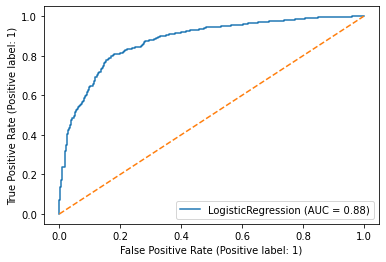

In [644]:
plot_roc_curve(model, X_train,y_train)
plt.plot([0, 1], [0, 1], linestyle='--');

In [645]:
# Accuracy - Test Data
model.score(X_test, y_test)

0.8552631578947368

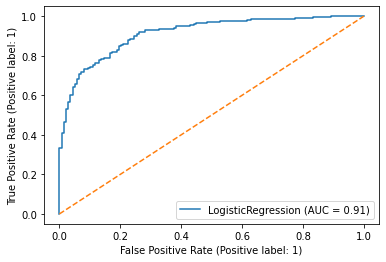

In [646]:
plot_roc_curve(model, X_test, y_test);
plt.plot([0,1],[0,1], linestyle='--');

### Confusion Matrix - Training Data

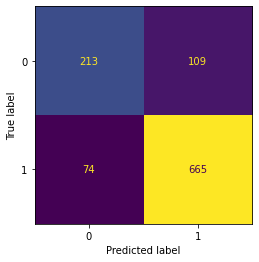

In [647]:
plot_confusion_matrix(model,X_train,y_train, colorbar=False);

In [648]:
print(classification_report(y_train, ytrain_predict))

              precision    recall  f1-score   support

           0       0.74      0.66      0.70       322
           1       0.86      0.90      0.88       739

    accuracy                           0.83      1061
   macro avg       0.80      0.78      0.79      1061
weighted avg       0.82      0.83      0.82      1061



### Confusion Matrix - Testing Data

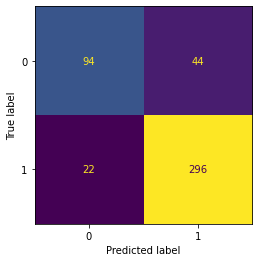

In [649]:
plot_confusion_matrix(model,X_test,y_test, colorbar=False);

In [650]:
print(classification_report(y_test, ytest_predict))

              precision    recall  f1-score   support

           0       0.81      0.68      0.74       138
           1       0.87      0.93      0.90       318

    accuracy                           0.86       456
   macro avg       0.84      0.81      0.82       456
weighted avg       0.85      0.86      0.85       456



### Tuning

## Linear Discriminant Analysis

In [651]:
X = df_dummy.drop('vote_Labour',axis=1)
y = df_dummy['vote_Labour']

In [652]:
X_train,X_test,y_train,y_test=train_test_split(X,
                                               y,
                                               test_size=0.30,
                                               random_state=1,
                                               stratify = y)

### Build LDA Model & Train & Classification Reports

In [653]:
clf = LinearDiscriminantAnalysis()
model=clf.fit(X_train,y_train)

In [654]:
# Training Data Class Prediction with a cut-off value of 0.5
pred_class_train = model.predict(X_train)

# Test Data Class Prediction with a cut-off value of 0.5
pred_class_test = model.predict(X_test)

LDA_train_score = model.score(X_train, y_train)
LDA_train_recall_score = recall_score(y_train,pred_class_train)
print(LDA_train_score,LDA_train_recall_score)


LDA_test_predict = model.predict(X_test)
LDA_test_score = model.score(X_test, y_test)
LDA_test_recall_score = recall_score(y_test,pred_class_test)
print(LDA_test_score,LDA_test_recall_score)

0.822808671065033 0.8876860622462788
0.8530701754385965 0.9245283018867925


              precision    recall  f1-score   support

           0       0.72      0.67      0.70       322
           1       0.86      0.89      0.87       739

    accuracy                           0.82      1061
   macro avg       0.79      0.78      0.79      1061
weighted avg       0.82      0.82      0.82      1061



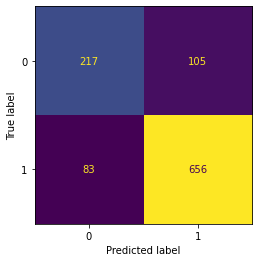

In [655]:
plot_confusion_matrix(model,X_train,y_train,colorbar = False);
print(classification_report(y_train,pred_class_train))

              precision    recall  f1-score   support

           0       0.80      0.69      0.74       138
           1       0.87      0.92      0.90       318

    accuracy                           0.85       456
   macro avg       0.84      0.81      0.82       456
weighted avg       0.85      0.85      0.85       456



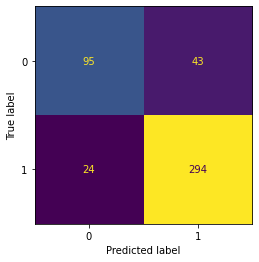

In [656]:
plot_confusion_matrix(model,X_test,y_test, colorbar=False)
print(classification_report(y_test,pred_class_test))

In [657]:
pred_train_prob = model.predict_proba(X_train)
pred_test_prob = model.predict_proba(X_test)

auc_train = roc_auc_score(y_train,pred_train_prob[:,1])
auc_test = roc_auc_score(y_test,pred_test_prob[:,1])

### AUC and ROC Curve

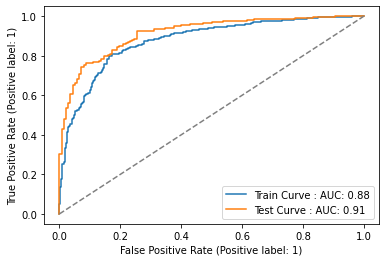

In [658]:
fig,ax = plt.subplots()
plot_roc_curve(model, X_train,y_train,ax=ax, 
               label = 'Train Curve : AUC: '+str(round(auc_train,2)));
plot_roc_curve(model, X_test, y_test, ax=ax,
              label = 'Test Curve : AUC: '+ str(round(auc_test,2)));
plt.plot([0,1],[0,1], linestyle='--', color = 'grey');

## Naive Bayes

In [659]:
from sklearn import metrics

X = df_dummy.drop('vote_Labour',axis=1)
y = df_dummy['vote_Labour']

In [660]:
X_train,X_test,y_train,y_test=train_test_split(X,
                                               y,
                                               test_size=0.30,
                                               random_state=1,
                                               stratify = y)

In [661]:
NB_model = GaussianNB()
NB_model.fit(X_train, y_train)

GaussianNB()

### Performance Metrics

In [662]:
y_train_predict = NB_model.predict(X_train)
model_score = NB_model.score(X_train, y_train)   
nb_train_recall_score = recall_score(y_train, y_train_predict)## Accuracy
print(model_score)
print(metrics.confusion_matrix(y_train, y_train_predict))          ## confusion_matrix
print(metrics.classification_report(y_train, y_train_predict))     ## classification_report

0.8199811498586239
[[226  96]
 [ 95 644]]
              precision    recall  f1-score   support

           0       0.70      0.70      0.70       322
           1       0.87      0.87      0.87       739

    accuracy                           0.82      1061
   macro avg       0.79      0.79      0.79      1061
weighted avg       0.82      0.82      0.82      1061



In [663]:
## Performance Matrix on test data set
y_test_predict = NB_model.predict(X_test)
model_score = NB_model.score(X_test, y_test)    
nb_test_recall_score = recall_score(y_test, y_test_predict)## Accuracy## Accuracy
print(model_score)
print(metrics.confusion_matrix(y_test, y_test_predict))         ## confusion_matrix
print(metrics.classification_report(y_test, y_test_predict))    ## classification_report

0.8574561403508771
[[100  38]
 [ 27 291]]
              precision    recall  f1-score   support

           0       0.79      0.72      0.75       138
           1       0.88      0.92      0.90       318

    accuracy                           0.86       456
   macro avg       0.84      0.82      0.83       456
weighted avg       0.86      0.86      0.86       456



## KNN

In [664]:
X = df_dummy.drop('vote_Labour',axis=1)
y = df_dummy['vote_Labour']

In [665]:
X_train,X_test,y_train,y_test=train_test_split(X,
                                               y,
                                               test_size=0.30,
                                               random_state=1,
                                               stratify = y)

In [666]:
from sklearn.neighbors import KNeighborsClassifier

KNN_model=KNeighborsClassifier()
KNN_model.fit(X_train,y_train)

KNeighborsClassifier()

### Performance Metrics for K = 5

In [667]:
## Performance Matrix on train data set
y_train_predict = KNN_model.predict(X_train)
model_score = KNN_model.score(X_train, y_train)
knn_train_recall_score = recall_score(y_train, y_train_predict)## Accuracy
print(model_score)
print(metrics.confusion_matrix(y_train, y_train_predict))
print(metrics.classification_report(y_train, y_train_predict))

0.8586239396795476
[[234  88]
 [ 62 677]]
              precision    recall  f1-score   support

           0       0.79      0.73      0.76       322
           1       0.88      0.92      0.90       739

    accuracy                           0.86      1061
   macro avg       0.84      0.82      0.83      1061
weighted avg       0.86      0.86      0.86      1061



In [668]:
## Performance Matrix on test data set
y_test_predict = KNN_model.predict(X_test)
model_score = KNN_model.score(X_test, y_test)
knn_test_recall_score = recall_score(y_test, y_test_predict)## Accuracy## Accuracy
print(model_score)
print(metrics.confusion_matrix(y_test, y_test_predict))
print(metrics.classification_report(y_test, y_test_predict))

0.8486842105263158
[[ 99  39]
 [ 30 288]]
              precision    recall  f1-score   support

           0       0.77      0.72      0.74       138
           1       0.88      0.91      0.89       318

    accuracy                           0.85       456
   macro avg       0.82      0.81      0.82       456
weighted avg       0.85      0.85      0.85       456



Default value n_neighbors=5, lets check the performance for K=7

In [669]:
KNN_model=KNeighborsClassifier(n_neighbors=7)
KNN_model.fit(X_train,y_train)

KNeighborsClassifier(n_neighbors=7)

### Performance Metrics for K=7

In [670]:
## Performance Matrix on train data set
y_train_predict = KNN_model.predict(X_train)
model_score = KNN_model.score(X_train, y_train)
print(model_score)
print(metrics.confusion_matrix(y_train, y_train_predict))
print(metrics.classification_report(y_train, y_train_predict))

0.8463713477851084
[[229  93]
 [ 70 669]]
              precision    recall  f1-score   support

           0       0.77      0.71      0.74       322
           1       0.88      0.91      0.89       739

    accuracy                           0.85      1061
   macro avg       0.82      0.81      0.81      1061
weighted avg       0.84      0.85      0.84      1061



In [671]:
## Performance Matrix on test data set
y_test_predict = KNN_model.predict(X_test)
model_score = KNN_model.score(X_test, y_test)
print(model_score)
print(metrics.confusion_matrix(y_test, y_test_predict))
print(metrics.classification_report(y_test, y_test_predict))

0.8508771929824561
[[ 98  40]
 [ 28 290]]
              precision    recall  f1-score   support

           0       0.78      0.71      0.74       138
           1       0.88      0.91      0.90       318

    accuracy                           0.85       456
   macro avg       0.83      0.81      0.82       456
weighted avg       0.85      0.85      0.85       456



## Decision Tree

In [672]:
from sklearn import tree

DT_model= tree.DecisionTreeClassifier()
DT_model.fit(X_train, y_train)

DecisionTreeClassifier()

In [673]:
## Performance Matrix on train data set
DT_train_predict = DT_model.predict(X_train)
DT_train_score = DT_model.score(X_train, y_train)
DT_train_recall_score = recall_score(y_train,DT_train_predict)
print(DT_train_score,DT_train_recall_score)

1.0 1.0


              precision    recall  f1-score   support

           0       1.00      1.00      1.00       322
           1       1.00      1.00      1.00       739

    accuracy                           1.00      1061
   macro avg       1.00      1.00      1.00      1061
weighted avg       1.00      1.00      1.00      1061



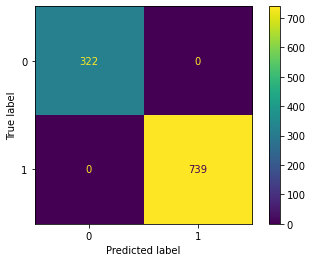

In [674]:
plot_confusion_matrix(DT_model,X_train,y_train)
plt.grid(b=False);
print(classification_report(y_train, DT_train_predict))

In [675]:
## Performance Matrix on test data set
DT_test_predict = DT_model.predict(X_test)
DT_test_score = DT_model.score(X_test, y_test)
DT_test_recall_score = recall_score(y_test, DT_test_predict)
print(DT_test_score,DT_test_recall_score)

0.7807017543859649 0.8553459119496856


              precision    recall  f1-score   support

           0       0.65      0.61      0.63       138
           1       0.83      0.86      0.84       318

    accuracy                           0.78       456
   macro avg       0.74      0.73      0.74       456
weighted avg       0.78      0.78      0.78       456



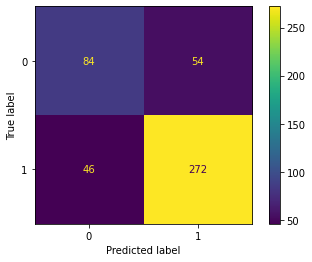

In [676]:
plot_confusion_matrix(DT_model, X_test, y_test)
plt.grid(b=False);
print(classification_report(y_test, DT_test_predict))

## Random Forest

In [677]:
from sklearn.ensemble import RandomForestClassifier

RF_model=RandomForestClassifier(n_estimators=100,random_state=1)
RF_model.fit(X_train, y_train)

RandomForestClassifier(random_state=1)

In [678]:
## Performance Matrix on train data set
RF_train_predict = RF_model.predict(X_train)
RF_train_score =RF_model.score(X_train, y_train)
RF_train_recall_score = recall_score(y_train,RF_train_predict)
print(RF_train_score,RF_train_recall_score)

1.0 1.0


              precision    recall  f1-score   support

           0       1.00      1.00      1.00       322
           1       1.00      1.00      1.00       739

    accuracy                           1.00      1061
   macro avg       1.00      1.00      1.00      1061
weighted avg       1.00      1.00      1.00      1061



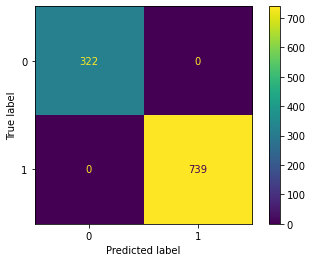

In [679]:
plot_confusion_matrix(RF_model, X_train,y_train)
plt.grid(b=False);
print(classification_report(y_train, RF_train_predict))

In [680]:
## Performance Matrix on test data set
RF_test_predict = RF_model.predict(X_test)
RF_test_score = RF_model.score(X_test, y_test)
RF_test_recall_score = recall_score(y_test, RF_test_predict)
print(RF_test_score,RF_test_recall_score)

0.8421052631578947 0.9088050314465409


              precision    recall  f1-score   support

           0       0.77      0.69      0.73       138
           1       0.87      0.91      0.89       318

    accuracy                           0.84       456
   macro avg       0.82      0.80      0.81       456
weighted avg       0.84      0.84      0.84       456



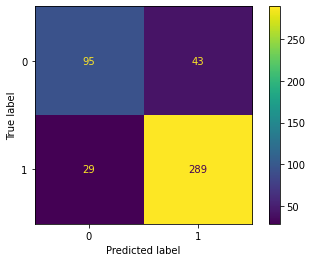

In [681]:
plot_confusion_matrix(RF_model,X_test,y_test)
plt.grid(b=False);
print(classification_report(y_test, RF_test_predict))

## Bagging

In [682]:
X = df_dummy.drop('vote_Labour',axis=1)
y = df_dummy['vote_Labour']

In [683]:
X_train,X_test,y_train,y_test=train_test_split(X,
                                               y,
                                               test_size=0.30,
                                               random_state=1,
                                               stratify = y)

In [684]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
cart = DecisionTreeClassifier()
Bagging_model=BaggingClassifier(base_estimator=cart,
                                n_estimators=100,
                                random_state=1)
Bagging_model.fit(X_train, y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(), n_estimators=100,
                  random_state=1)

### Performance Metrics

In [685]:
## Performance Matrix on train data set
Bagging_train_predict = Bagging_model.predict(X_train)
Bagging_train_score =Bagging_model.score(X_train, y_train)
Bagging_train_recall_score = recall_score(y_train,Bagging_train_predict)
print(Bagging_train_score, Bagging_train_recall_score)

1.0 1.0


              precision    recall  f1-score   support

           0       1.00      1.00      1.00       322
           1       1.00      1.00      1.00       739

    accuracy                           1.00      1061
   macro avg       1.00      1.00      1.00      1061
weighted avg       1.00      1.00      1.00      1061



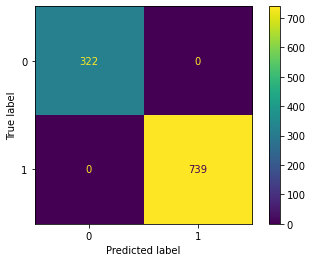

In [686]:
plot_confusion_matrix(Bagging_model,X_train, y_train)
plt.grid(b=False);
print(classification_report(y_train, Bagging_train_predict))

0.8399122807017544 0.9056603773584906
              precision    recall  f1-score   support

           0       0.76      0.69      0.72       138
           1       0.87      0.91      0.89       318

    accuracy                           0.84       456
   macro avg       0.82      0.80      0.80       456
weighted avg       0.84      0.84      0.84       456



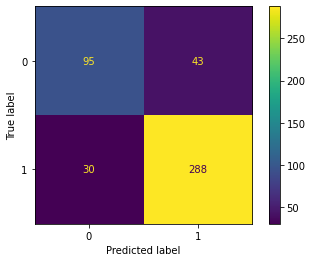

In [687]:
## Performance Matrix on test data set
Bagging_test_predict = Bagging_model.predict(X_test)
Bagging_test_score = Bagging_model.score(X_test, y_test)
Bagging_test_recall_score = recall_score(y_test, Bagging_test_predict)
print(Bagging_test_score, Bagging_test_recall_score)
plot_confusion_matrix(Bagging_model,X_test,y_test)
plt.grid(b=False);
print(classification_report(y_test, Bagging_test_predict))

## Boosting

In [688]:
from sklearn.ensemble import AdaBoostClassifier

In [689]:
X = df_dummy.drop('vote_Labour',axis=1)
y = df_dummy['vote_Labour']

In [690]:
X_train,X_test,y_train,y_test=train_test_split(X,
                                               y,
                                               test_size=0.30,
                                               random_state=1,
                                               stratify = y)

In [691]:
ADB_model = AdaBoostClassifier(n_estimators=100,random_state=1)
ADB_model.fit(X_train,y_train)

AdaBoostClassifier(n_estimators=100, random_state=1)

In [692]:
ADB_train_predict = ADB_model.predict(X_train)
ADB_train_score = ADB_model.score(X_train, y_train)
ADB_train_recall_score = recall_score(y_train,ADB_train_predict)
print(ADB_train_score,ADB_train_recall_score)

0.8491988689915174 0.9106901217861976


### Performance Metrics Train

              precision    recall  f1-score   support

           0       0.78      0.71      0.74       322
           1       0.88      0.91      0.89       739

    accuracy                           0.85      1061
   macro avg       0.83      0.81      0.82      1061
weighted avg       0.85      0.85      0.85      1061



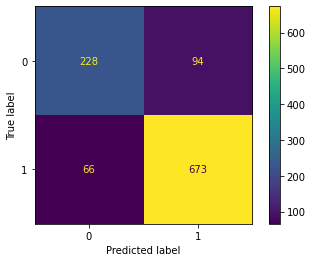

In [693]:
plot_confusion_matrix(ADB_model,X_train,y_train);
plt.grid(b=False);
print(classification_report(y_train, ADB_train_predict))

### Performance Metrics Test

In [694]:
## Performance Matrix on test data set
ADB_test_predict = ADB_model.predict(X_test)
ADB_test_score = ADB_model.score(X_test, y_test)
ADB_test_recall_score = recall_score(y_test,ADB_test_predict)
print(ADB_test_score,ADB_test_recall_score)

0.8355263157894737 0.89937106918239


              precision    recall  f1-score   support

           0       0.75      0.69      0.72       138
           1       0.87      0.90      0.88       318

    accuracy                           0.84       456
   macro avg       0.81      0.79      0.80       456
weighted avg       0.83      0.84      0.83       456



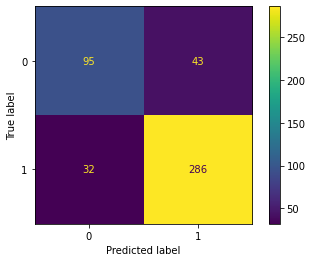

In [695]:
plot_confusion_matrix(ADB_model,X_test,y_test)
plt.grid(b=False);
print(classification_report(y_test, ADB_test_predict))

## Gradient Boosting

In [696]:
X = df_dummy.drop('vote_Labour',axis=1)
y = df_dummy['vote_Labour']

In [697]:
X_train,X_test,y_train,y_test=train_test_split(X,
                                               y,
                                               test_size=0.30,
                                               random_state=1,
                                               stratify = y)

In [698]:
from sklearn.ensemble import GradientBoostingClassifier
gbcl = GradientBoostingClassifier(random_state=1)
gbcl

GradientBoostingClassifier(random_state=1)

In [699]:
gbcl = gbcl.fit(X_train, y_train)
gbcl

GradientBoostingClassifier(random_state=1)

In [700]:
## Performance Matrix on train data set
gbcl_train_predict = gbcl.predict(X_train)
gbcl_train_score = gbcl.score(X_train, y_train)
gbcl_train_recall_score = recall_score(y_train,gbcl_train_predict)
print(gbcl_train_score,gbcl_train_recall_score)

0.885956644674835 0.9336941813261164


### Performance Metrics Train

              precision    recall  f1-score   support

           0       0.84      0.78      0.81       322
           1       0.91      0.93      0.92       739

    accuracy                           0.89      1061
   macro avg       0.87      0.86      0.86      1061
weighted avg       0.88      0.89      0.88      1061



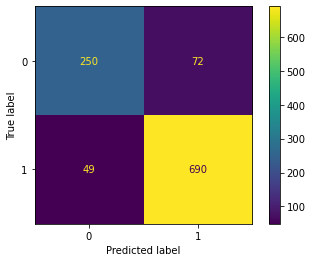

In [701]:
plot_confusion_matrix(gbcl,X_train,y_train)
plt.grid(b=False);
print(classification_report(y_train, gbcl_train_predict))

### Performance Metrics Test

In [702]:
## Performance Matrix on test data set
gbcl_test_predict = gbcl.predict(X_test)
gbcl_test_score = gbcl.score(X_test, y_test)
gbcl_test_recall_score = recall_score(y_test, gbcl_test_predict)
print(gbcl_test_score,gbcl_test_recall_score)

0.8421052631578947 0.9088050314465409


              precision    recall  f1-score   support

           0       0.77      0.69      0.73       138
           1       0.87      0.91      0.89       318

    accuracy                           0.84       456
   macro avg       0.82      0.80      0.81       456
weighted avg       0.84      0.84      0.84       456



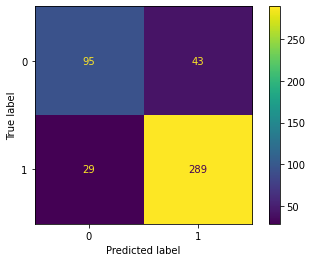

In [703]:
plot_confusion_matrix(gbcl,X_test,y_test)
plt.grid(b=False);
print(classification_report(y_test, gbcl_test_predict))

In [704]:
def get_best_model_GridSearchCV(model, grid, crossvalid, jobs, score, X_train, y_train):
    grid_search = GridSearchCV(estimator = model, param_grid = grid, cv = crossvalid,n_jobs=jobs,scoring=score)
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_
    best_model.fit(X_train, y_train)
    return {'grid_search_cv': grid_search,'best_model':best_model}

In [705]:
def print_metrics(model, X, y, train_predict, dtype):
    matrix = plot_confusion_matrix(model,X,y, colorbar=False)
    matrix_title = 'Confusion Matrix For ' + dtype
    matrix.ax_.set_title(matrix_title)
    print('Classification Report for',dtype,'Data:-> \n')
    print(classification_report(y, train_predict),'\n');

In [706]:
def print_best_features(X_train, best_model):
    coef_df = pd.DataFrame({'columns': X_train.columns, 'coef': best_model.coef_[0]})
    sorted_coef_values = coef_df.sort_values('coef', ascending=False)
    plt.figure(figsize=(10,10))
    sns.barplot(x='coef', y='columns', data=sorted_coef_values)
    plt.xlabel('Coefficents from Linear Regression Model')
    plt.ylabel('Features')
    plt.title('Best Features')
    plt.show()

In [707]:
def build_model(grid, model, df, cv, jobs, scoring, no_best_features=True):
    X = df_dummy.drop(['vote_Labour'], axis=1)
    y = df_dummy['vote_Labour']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30 , random_state=1, stratify=df_dummy['vote_Labour']) # stratify = y
    
    ret_obj = get_best_model_GridSearchCV(model, grid, cv, jobs, scoring, X_train, y_train)
    grid_search = ret_obj['grid_search_cv']
    best_model = ret_obj['best_model']
    print('Grid Search CV:->\n', grid_search)
    print('Best model:->\n',best_model)
    
    ytrain_predict = best_model.predict(X_train)
    ytest_predict = best_model.predict(X_test)  
    print('Predict Probablities for Test:-> \n')
    ytest_predict_prob=best_model.predict_proba(X_test)
    
    print(pd.DataFrame(ytest_predict_prob).head())
    
    print_metrics(best_model,X_train,y_train, ytrain_predict, 'Training')
    
    print_metrics(best_model,X_test,y_test, ytest_predict, 'Testing')
    
    if(no_best_features):
        print_best_features(X_train, best_model)

## GridSearchCV

In [708]:
X = df_dummy.drop(['vote_Labour'], axis=1)
y = df_dummy['vote_Labour']

In [709]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30 , random_state=1, stratify=df_dummy['vote_Labour']) # stratify = y

### Logistic Regression

Grid Search CV:->
 GridSearchCV(cv=5,
             estimator=LogisticRegression(max_iter=10000, n_jobs=2,
                                          random_state=1),
             n_jobs=-1,
             param_grid={'l1_ratio': [0.25, 0.5, 0.75],
                         'penalty': ['l2', 'none', 'l1', 'elasticnet'],
                         'solver': ['sag', 'lbfgs', 'saga', 'newton-cg',
                                    'liblinear'],
                         'tol': [0.0001, 1e-05]},
             scoring='f1')
Best model:->
 LogisticRegression(l1_ratio=0.25, max_iter=10000, n_jobs=2, penalty='l1',
                   random_state=1, solver='saga')
Predict Probablities for Test:-> 

          0         1
0  0.199881  0.800119
1  0.613892  0.386108
2  0.087125  0.912875
3  0.031959  0.968041
4  0.139152  0.860848
Classification Report for Training Data:-> 

              precision    recall  f1-score   support

           0       0.74      0.66      0.70       322
           1       0.86

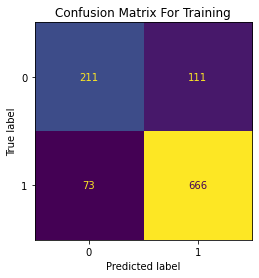

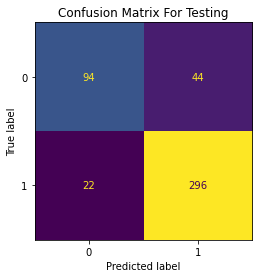

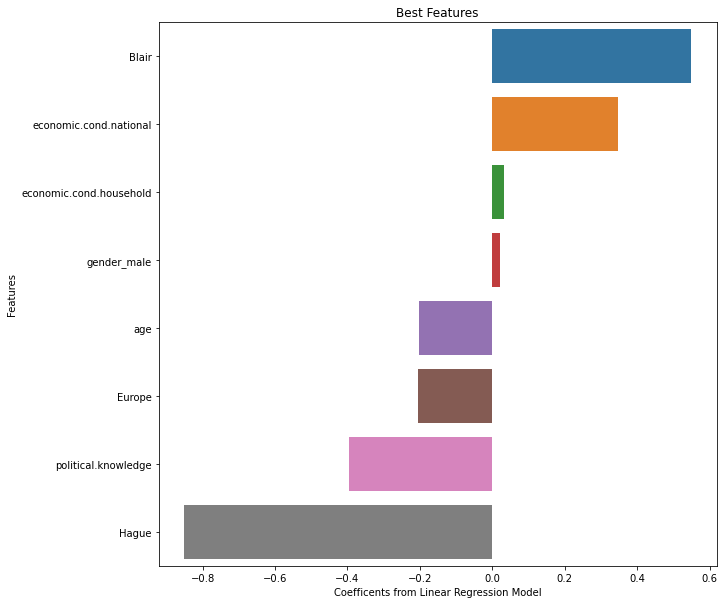

In [710]:
grid={
    'penalty':['l2','none','l1','elasticnet'],
    'solver':['sag','lbfgs','saga','newton-cg','liblinear'],
    'tol':[0.0001,0.00001], # 0.1, 0.01,0.001,
    'l1_ratio':[0.25,0.5,0.75]
    } #'max_iter':[100,1000,10000]
model = LogisticRegression(max_iter=10000,n_jobs=2,random_state=1)
build_model(grid, model, df_dummy, 5, -1, 'f1')

### Linear Discriminant Analysis

Grid Search CV:->
 GridSearchCV(cv=5, estimator=LinearDiscriminantAnalysis(), n_jobs=-1,
             param_grid={'solver': ['svd', 'lsqr', 'eigen'],
                         'tol': [0.0001, 1e-05]},
             scoring='f1')
Best model:->
 LinearDiscriminantAnalysis()
Predict Probablities for Test:-> 

          0         1
0  0.165344  0.834656
1  0.658755  0.341245
2  0.075012  0.924988
3  0.019620  0.980380
4  0.118369  0.881631
Classification Report for Training Data:-> 

              precision    recall  f1-score   support

           0       0.72      0.67      0.70       322
           1       0.86      0.89      0.87       739

    accuracy                           0.82      1061
   macro avg       0.79      0.78      0.79      1061
weighted avg       0.82      0.82      0.82      1061
 

Classification Report for Testing Data:-> 

              precision    recall  f1-score   support

           0       0.80      0.69      0.74       138
           1       0.87      0.92  

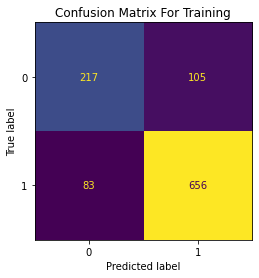

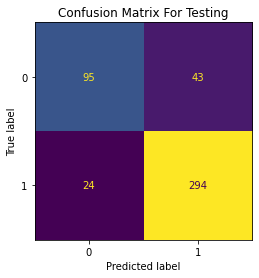

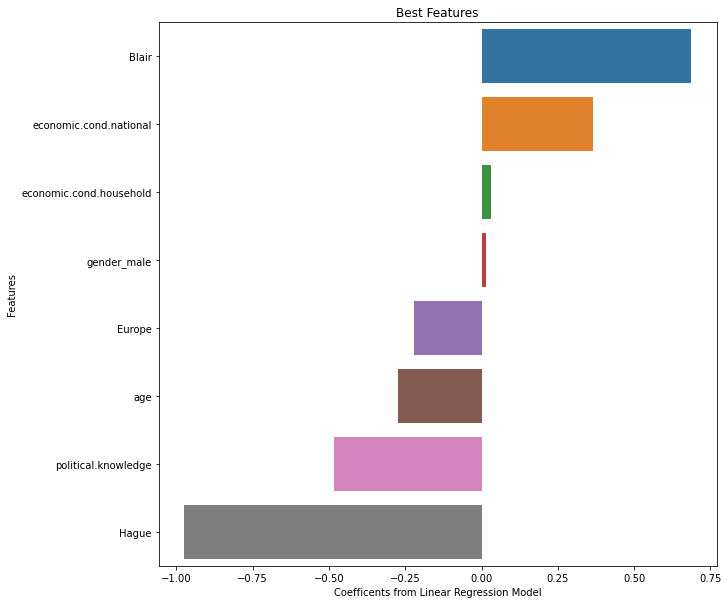

In [711]:
grid={
    'solver':['svd', 'lsqr', 'eigen'],
    'tol':[0.0001,0.00001], # 0.1, 0.01,0.001
    } #'max_iter':[100,1000,10000]
clf = LinearDiscriminantAnalysis()
build_model(grid, clf, df_dummy, 5, -1, 'f1')

### KNN


----------------->>>>>>>>>>>>>>>
----------->>>>> K Value:  4
Grid Search CV:->
 GridSearchCV(cv=5, estimator=KNeighborsClassifier(n_neighbors=4), n_jobs=-1,
             param_grid={'weights': ['uniform', 'distance']}, scoring='f1')
Best model:->
 KNeighborsClassifier(n_neighbors=4, weights='distance')
Predict Probablities for Test:-> 

          0         1
0  0.000000  1.000000
1  0.524741  0.475259
2  0.259328  0.740672
3  0.000000  1.000000
4  0.214261  0.785739
Classification Report for Training Data:-> 

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       322
           1       1.00      1.00      1.00       739

    accuracy                           1.00      1061
   macro avg       1.00      1.00      1.00      1061
weighted avg       1.00      1.00      1.00      1061
 

Classification Report for Testing Data:-> 

              precision    recall  f1-score   support

           0       0.73      0.72      0.73       138


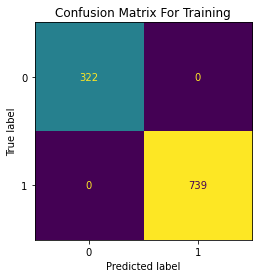

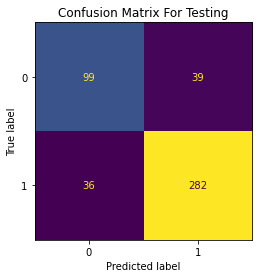

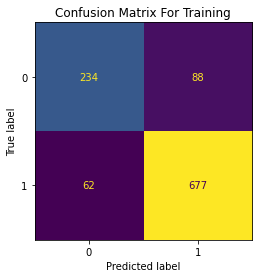

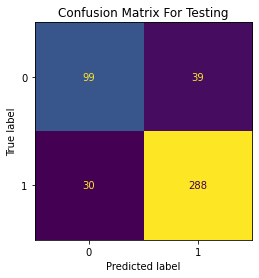

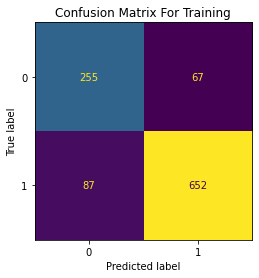

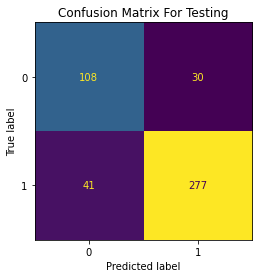

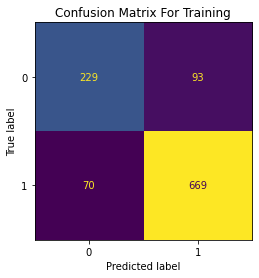

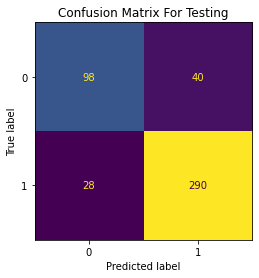

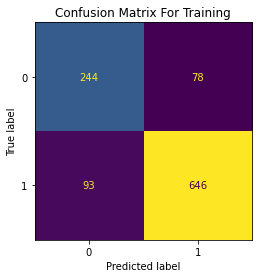

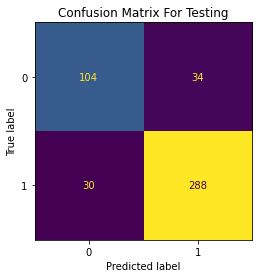

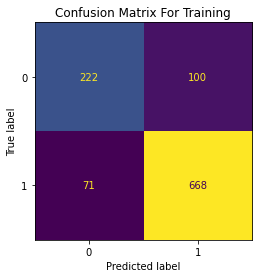

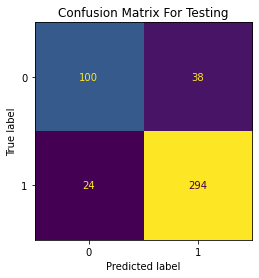

In [712]:
for i in range(10):
    if(i > 3):
        print('\n----------------->>>>>>>>>>>>>>>')
        print('----------->>>>> K Value: ', i)
        KNN_model=KNeighborsClassifier(n_neighbors=i, algorithm='auto', leaf_size=30,
                                                    metric='minkowski',
                                                    metric_params=None, n_jobs=None,
                                                    p=2,
                                                    weights='uniform')
        grid={
            'weights': ['uniform', 'distance']
            } #'max_iter':[100,1000,10000]
        build_model(grid, KNN_model, df_dummy, 5, -1, 'f1', False)

### Decision Tree

Grid Search CV:->
 GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=1), n_jobs=-1,
             param_grid={'max_leaf_nodes': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                            13, 14, 15, 16, 17, 18, 19, 20, 21,
                                            22, 23, 24, 25, 26, 27, 28, 29, 30,
                                            31, ...],
                         'min_samples_split': [2, 3, 4]},
             scoring='f1')
Best model:->
 DecisionTreeClassifier(max_leaf_nodes=21, random_state=1)
Predict Probablities for Test:-> 

          0         1
0  0.067391  0.932609
1  0.452381  0.547619
2  0.000000  1.000000
3  0.067391  0.932609
4  0.067391  0.932609
Classification Report for Training Data:-> 

              precision    recall  f1-score   support

           0       0.79      0.70      0.75       322
           1       0.88      0.92      0.90       739

    accuracy                           0.85      1061
   macro avg       

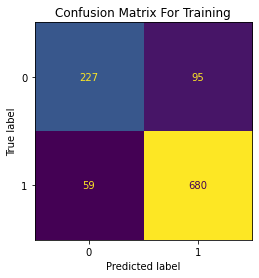

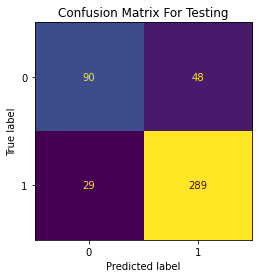

In [713]:
grid={
    'max_leaf_nodes': list(range(2, 100)), 'min_samples_split': [2, 3, 4]
    } #'max_iter':[100,1000,10000]
DT_model= tree.DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, random_state=1,
            splitter='best')
build_model(grid, DT_model, df_dummy, 5, -1, 'f1', False)


### Random Forest

Grid Search CV:->
 GridSearchCV(cv=5,
             estimator=RandomForestClassifier(max_features='sqrt',
                                              n_estimators=50, n_jobs=-1,
                                              oob_score=True, random_state=1),
             n_jobs=-1,
             param_grid={'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [200, 700, 900]},
             scoring='f1')
Best model:->
 RandomForestClassifier(n_estimators=900, n_jobs=-1, oob_score=True,
                       random_state=1)
Predict Probablities for Test:-> 

          0         1
0  0.337778  0.662222
1  0.551111  0.448889
2  0.170000  0.830000
3  0.043333  0.956667
4  0.222222  0.777778
Classification Report for Training Data:-> 

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       322
           1       1.00      1.00      1.00       739

    accuracy                           1.00      1061
   macro avg 

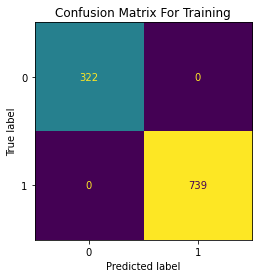

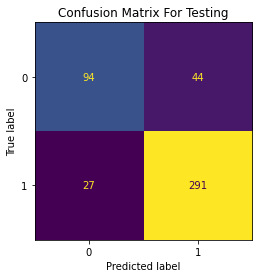

In [714]:
grid = { 
    'n_estimators': [200, 700, 900],
    'max_features': ['auto', 'sqrt', 'log2']
}

RF_model=RandomForestClassifier(n_jobs=-1,max_features= 'sqrt' ,n_estimators=50, oob_score = True, random_state=1)

build_model(grid, RF_model, df_dummy, 5, -1, 'f1', False)


### Bagging

Grid Search CV:->
 GridSearchCV(cv=5,
             estimator=BaggingClassifier(base_estimator=DecisionTreeClassifier(),
                                         n_estimators=100, random_state=1),
             n_jobs=-1,
             param_grid={'max_features': [4, 6],
                         'n_estimators': [200, 700, 900]},
             scoring='f1')
Best model:->
 BaggingClassifier(base_estimator=DecisionTreeClassifier(), max_features=4,
                  n_estimators=900, random_state=1)
Predict Probablities for Test:-> 

          0         1
0  0.322548  0.677452
1  0.641506  0.358494
2  0.213518  0.786482
3  0.150062  0.849938
4  0.143517  0.856483
Classification Report for Training Data:-> 

              precision    recall  f1-score   support

           0       0.99      0.89      0.94       322
           1       0.96      1.00      0.98       739

    accuracy                           0.97      1061
   macro avg       0.97      0.95      0.96      1061
weighted avg       

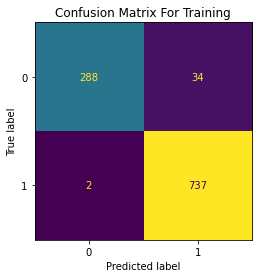

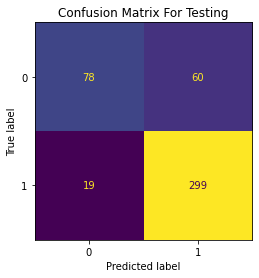

In [715]:
model = BaggingClassifier(base_estimator=cart,
                                n_estimators=100,
                                random_state=1)

grid = { 
    'n_estimators': [200, 700, 900],
    'max_features': [4, 6]
}

build_model(grid, model, df_dummy, 5, -1, 'f1', False)

### Boosting

Grid Search CV:->
 GridSearchCV(cv=5, estimator=AdaBoostClassifier(n_estimators=100), n_jobs=-1,
             param_grid={'n_estimators': [200, 400, 900]}, scoring='f1')
Best model:->
 AdaBoostClassifier(n_estimators=200)
Predict Probablities for Test:-> 

          0         1
0  0.498321  0.501679
1  0.500425  0.499575
2  0.497222  0.502778
3  0.495775  0.504225
4  0.496658  0.503342
Classification Report for Training Data:-> 

              precision    recall  f1-score   support

           0       0.77      0.70      0.73       322
           1       0.87      0.91      0.89       739

    accuracy                           0.84      1061
   macro avg       0.82      0.80      0.81      1061
weighted avg       0.84      0.84      0.84      1061
 

Classification Report for Testing Data:-> 

              precision    recall  f1-score   support

           0       0.74      0.67      0.71       138
           1       0.86      0.90      0.88       318

    accuracy                 

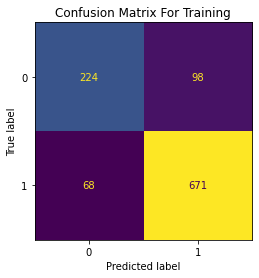

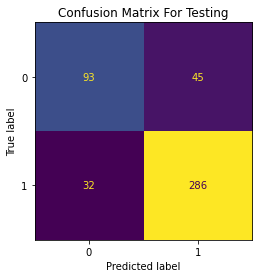

In [716]:
grid = {
    "n_estimators": [200, 400, 900]
    }

ABC = AdaBoostClassifier(n_estimators=100)

build_model(grid, ABC, df_dummy, 5, -1, 'f1', False)

Grid Search CV:->
 GridSearchCV(cv=5, estimator=GradientBoostingClassifier(random_state=1),
             n_jobs=-1,
             param_grid={'criterion': ['friedman_mse', 'mae'],
                         'max_features': ['log2', 'sqrt'],
                         'n_estimators': [200, 700, 900]},
             scoring='f1')
Best model:->
 GradientBoostingClassifier(max_features='sqrt', n_estimators=200,
                           random_state=1)
Predict Probablities for Test:-> 

          0         1
0  0.364427  0.635573
1  0.696531  0.303469
2  0.054147  0.945853
3  0.030122  0.969878
4  0.146105  0.853895
Classification Report for Training Data:-> 

              precision    recall  f1-score   support

           0       0.87      0.81      0.84       322
           1       0.92      0.95      0.93       739

    accuracy                           0.91      1061
   macro avg       0.89      0.88      0.89      1061
weighted avg       0.90      0.91      0.90      1061
 

Classificat

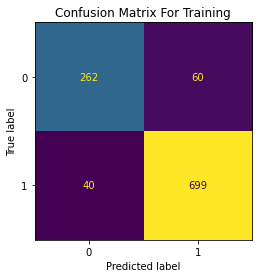

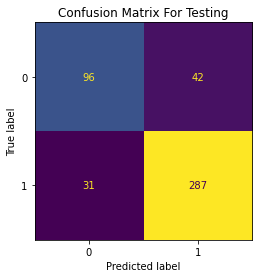

In [717]:
gbc = GradientBoostingClassifier(random_state=1)

grid = { 
    'n_estimators': [200, 700, 900],
    "max_features":["log2","sqrt"],
    "criterion": ["friedman_mse",  "mae"],
}

build_model(grid, gbc, df_dummy, 5, -1, 'f1', False)

## Summary, insights and recommendations.

In [718]:
model_names = ['Naive-Bayes','LDA','ADABoost',
              'GradientBoost','KNN','Bagging']

train_recalls = [nb_train_recall_score,LDA_train_recall_score,
                ADB_train_recall_score,gbcl_train_recall_score, 
                 knn_train_recall_score,
                Bagging_train_recall_score]
test_recalls = [nb_test_recall_score,LDA_test_recall_score,
               ADB_test_recall_score,knn_test_recall_score,
                gbcl_test_recall_score, Bagging_test_recall_score]

recall_df = pd.DataFrame({'train_recall':train_recalls,
                         'test_recall':test_recalls},
                        index=model_names)
recall_df



,train_recall,test_recall
Naive-Bayes,0.871448,0.915094
LDA,0.887686,0.924528
ADABoost,0.910690,0.899371
GradientBoost,0.933694,0.905660
KNN,0.916103,0.908805
Bagging,1.000000,0.905660


# Problem Statement
<b>
In this project, we are going to work on the inaugural corpora from the nltk in Python. We will be looking at the following speeches of the Presidents of the United States of America:

President Franklin D. Roosevelt in 1941
President John F. Kennedy in 1961
President Richard Nixon in 1973


## Find the number of characters, words and sentences for the mentioned documents. (Hint: use .words(), .raw(), .sent() for extracting counts).

## Remove all the stopwords from the three speeches. Show the word count before and after the removal of stopwords. Show a sample sentence after the removal of stopwords.

## Which word occurs the most number of times in his inaugural address for each president? Mention the top three words. (after removing the stopwords).

## Plot the word cloud of each of the three speeches. (after removing the stopwords). 

--------->Speech Analysis for President Roosvelt <----------
Total characters in President Roosvelt speech is:  7571
Total sentences in President Roosvelt speech is:  68
Total words in President Roosvelt speech is:  1526
Top 3 words of president Roosvelt are: ['national', 'day', 'inauguration']
 -- After stop words removal --
national day inauguration since people renewed sense dedication united states washington day task people create weld together nation lincoln day task people preserve nation disruption within day task people save
--------------------------------------------------
--------->Speech Analysis for President Kennedy <----------
Total characters in President Kennedy speech is:  7618
Total sentences in President Kennedy speech is:  52
Total words in President Kennedy speech is:  1543
Top 3 words of president Kennedy are: ['vice', 'president', 'johnson']
 -- After stop words removal --
vice president johnson mr speaker mr chief justice president eisenhower vice president ni

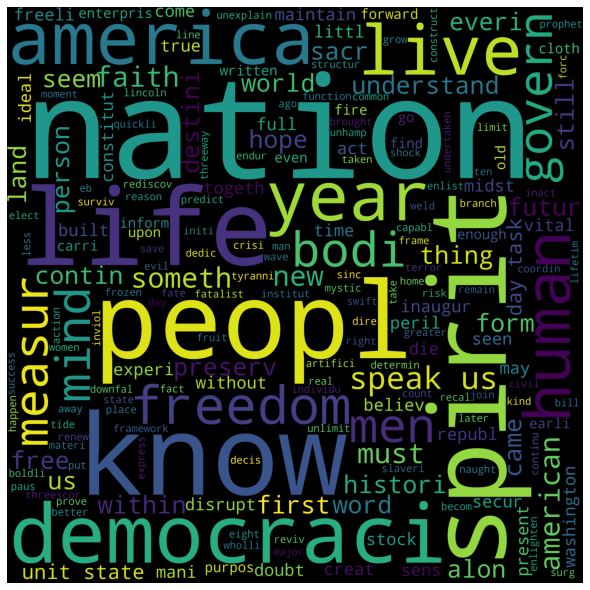

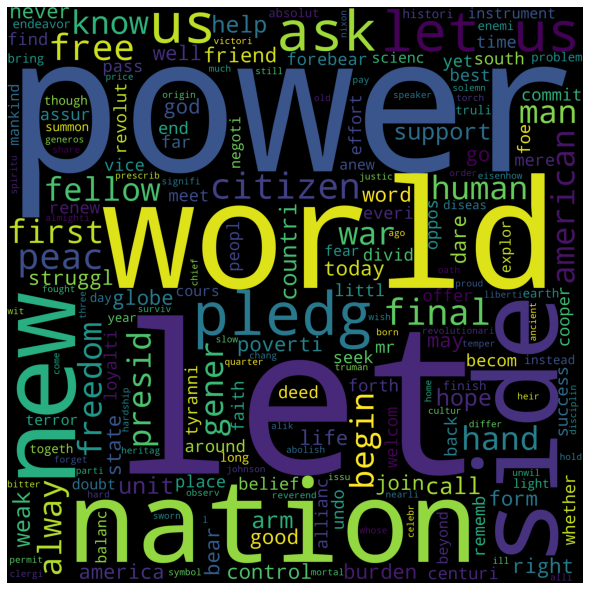

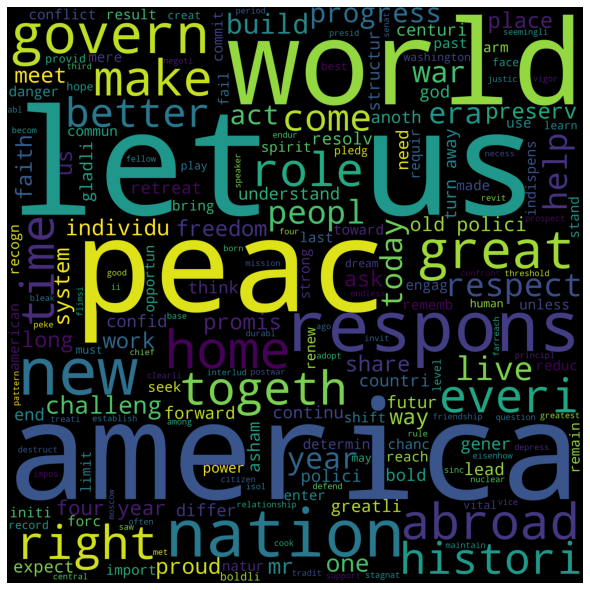

In [719]:
def analyze_text(text, president):    
    print('--------->Speech Analysis for President',president,'<----------')
    
    print('Total characters in President', president, 'speech is: ',len(text))
    
    from nltk import sent_tokenize
    sentences = sent_tokenize(text)
    print('Total sentences in President', president, 'speech is: ',len(sentences))

    # split into words
    from nltk.tokenize import word_tokenize
    tokens = word_tokenize(text)
    print('Total words in President', president, 'speech is: ',len(tokens))


    # convert to lower case
    tokens = [w.lower() for w in tokens]

    # remove punctuation from each word
    table = str.maketrans('', '', string.punctuation)
    stripped = [w.translate(table) for w in tokens]

    # remove remaining tokens that are not alphabetic
    words = [word for word in stripped if word.isalpha()]

    # filter out stop words
    from nltk.corpus import stopwords
    stop_words = set(stopwords.words('english'))
    words = [w for w in words if not w in stop_words]
    print('Top 3 words of president', president, 'are:', words[:3])

    # Text after stop words removal.
    print(' -- After stop words removal --')
    print(' '.join(words[:30]))
    
    # stemming of words
    from nltk.stem.porter import PorterStemmer
    porter = PorterStemmer()
    stemmed = [porter.stem(word) for word in words]
    
    
    final_text = ' '.join(stemmed)

    from wordcloud import WordCloud

    wordcloud = WordCloud(width = 3000, height = 3000, 
                    background_color ='black', 
                    min_font_size = 10, random_state=100).generate(final_text) 

    # plot the WordCloud image                        
    plt.figure(figsize = (8, 8), facecolor = None) 
    plt.imshow(wordcloud) 
    plt.axis("off")
    plt.xlabel('Word Cloud')
    plt.tight_layout(pad = 0) 
    
    print('--------------------------------------------------')

analyze_text(inaugural.raw('1941-Roosevelt.txt'), 'Roosvelt')
analyze_text(inaugural.raw('1961-Kennedy.txt'), 'Kennedy')
analyze_text(inaugural.raw('1973-Nixon.txt'), 'Nixon')